# Doing Benchmark Tests

In [1]:
from utils.libs import *

In [2]:
print(f"keras.__version__: {keras.__version__}")
print(f"sklearn.__version__: {sklearn.__version__}")
print(f"tf.__version__: {tf.__version__}")

keras.__version__: 2.4.3
sklearn.__version__: 0.23.1
tf.__version__: 2.2.0


In [3]:
opts = get_option_parser()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = opts.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

In [4]:
os.getcwd()

SEED = 1234
RANDOM_STATE = 42

N_FOLDS = 10

N_COMPONENTS = 2

target_names = ['Occupancy', 'Non-Occupancy']

np.random.seed(seed = SEED)

### Fetch Data: Training Set

In [5]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatraining.txt"

file_path = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [6]:
train_data = pd.read_csv(file_path)

In [7]:
train_data.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
unique,8143,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-09 15:08:59,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,NaN,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,NaN,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,NaN,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,NaN,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,NaN,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


### Fetch Data: Test Set

In [9]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatest.txt"

file_path_test_set = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [10]:
test_data = pd.read_csv(file_path_test_set)

In [11]:
test_data.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
unique,2665,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-02 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,NaN,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,NaN,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,NaN,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,NaN,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,NaN,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


## Benchmark

### Preprocess data

In [13]:
targets_idx = 6
def filter_targets_idx(xx, targets_idx):
    if type(targets_idx) is list:
        return xx not in targets_idx 
    return xx != targets_idx
features_idx = list(filter(lambda xx: filter_targets_idx(xx, targets_idx), range(len(train_data.columns))))[1:]

In [14]:
pprint(dict(zip("features_idx, targets_idx".split(","), [features_idx, targets_idx])))

{' targets_idx': 6, 'features_idx': [1, 2, 3, 4, 5]}


In [15]:
X_train, y_train, X_test, y_test, feature_names = \
    preprocess_data(
        train_data, test_data,
        opts, features_idx,
        targets_idx, random_state = RANDOM_STATE)

Preprocessing done in 0.024983s


In [16]:
feature_names

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [17]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_samples = X_train.shape[0]

print("n_classes: %d, \t n_samples: %d, \t n_features: %d"
      % (n_classes, n_samples, n_features))

n_classes: 2, 	 n_samples: 8143, 	 n_features: 5


### Perform benchmark

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.029s
test time:  0.000s
accuracy:   0.979
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       1.00      0.97      0.98      1693
Non-Occupancy       0.95      1.00      0.97       972

     accuracy                           0.98      2665
    macro avg       0.97      0.98      0.98      2665
 weighted avg       0.98      0.98      0.98      2665

permutation test:
Classification score 0.9882107932913766 (pvalue : 0.009900990099009901)


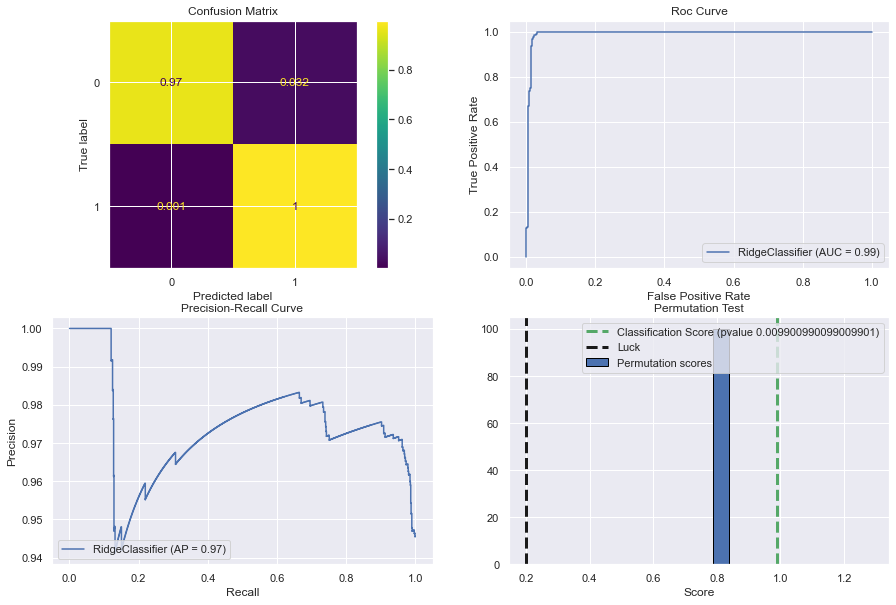


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.005s
test time:  0.000s
accuracy:   0.974
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       0.99      0.97      0.98      1693
Non-Occupancy       0.95      0.98      0.97       972

     accuracy                           0.97      2665
    macro avg       0.97      0.98      0.97      2665
 weighted avg       0.97      0.97      0.97      2665

permutation test:
Classification score 0.9785085303157751 (pvalue : 0.009900990099009901)


<Figure size 432x288 with 0 Axes>

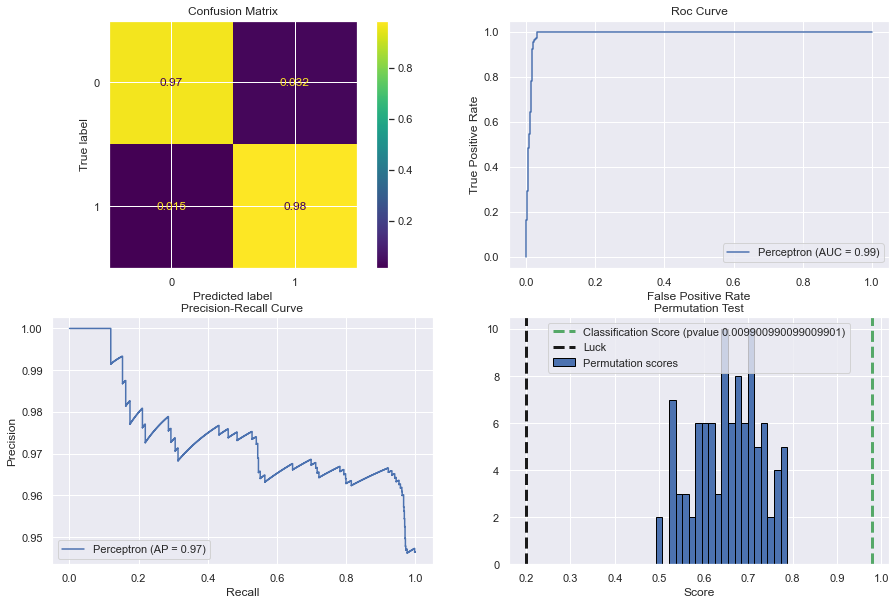


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.007s
test time:  0.001s
accuracy:   0.975
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       0.99      0.97      0.98      1693
Non-Occupancy       0.95      0.99      0.97       972

     accuracy                           0.97      2665
    macro avg       0.97      0.98      0.97      2665
 weighted avg       0.98      0.97      0.97      2665

permutation test:
Classification score 0.972490202153427 (pvalue : 0.009900990099009901)


<Figure size 432x288 with 0 Axes>

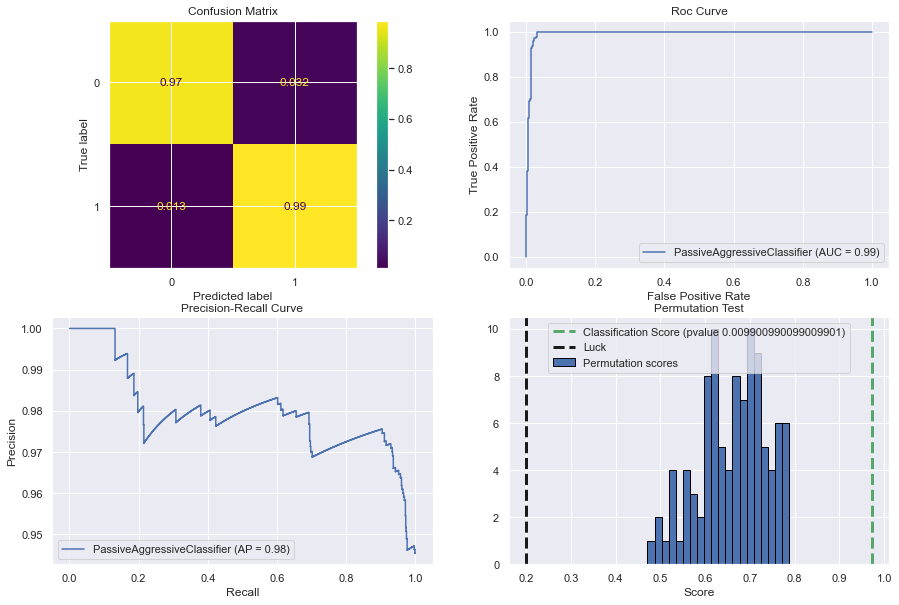


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.040s
test time:  0.125s
accuracy:   0.927
classification report:
               precision    recall  f1-score   support

    Occupancy       0.91      0.98      0.94      1693
Non-Occupancy       0.97      0.83      0.89       972

     accuracy                           0.93      2665
    macro avg       0.94      0.91      0.92      2665
 weighted avg       0.93      0.93      0.93      2665

permutation test:
Classification score 0.9920175782126586 (pvalue : 0.009900990099009901)


<Figure size 432x288 with 0 Axes>

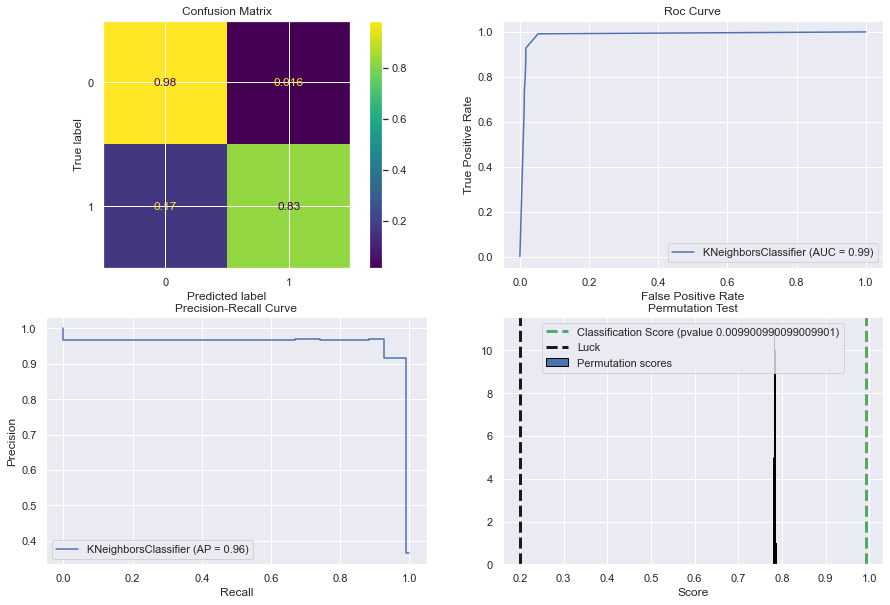


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.515s
test time:  0.029s
accuracy:   0.950
classification report:
               precision    recall  f1-score   support

    Occupancy       0.95      0.97      0.96      1693
Non-Occupancy       0.94      0.92      0.93       972

     accuracy                           0.95      2665
    macro avg       0.95      0.94      0.95      2665
 weighted avg       0.95      0.95      0.95      2665

permutation test:
Classification score 0.9925087373482184 (pvalue : 0.009900990099009901)


<Figure size 432x288 with 0 Axes>

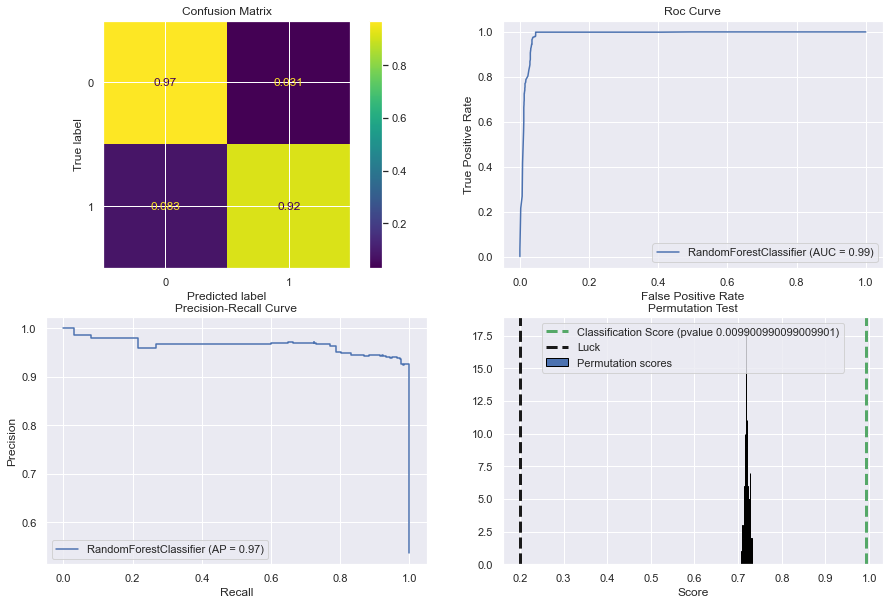


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.006s
test time:  0.001s
accuracy:   0.974
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       0.99      0.97      0.98      1693
Non-Occupancy       0.95      0.98      0.97       972

     accuracy                           0.97      2665
    macro avg       0.97      0.98      0.97      2665
 weighted avg       0.97      0.97      0.97      2665

permutation test:
Classification score 0.9861229748583469 (pvalue : 0.009900990099009901)


<Figure size 432x288 with 0 Axes>

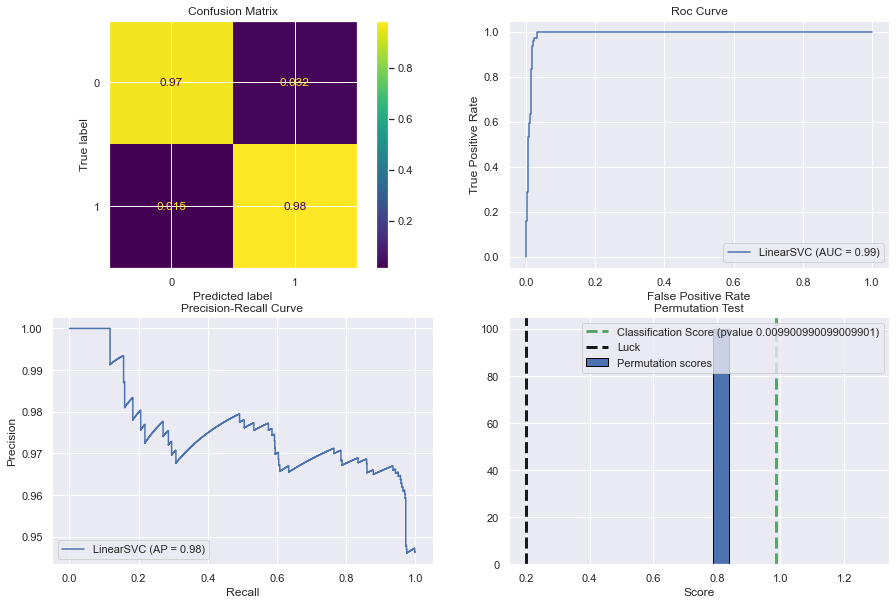


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, penalty='l1', tol=0.001)
train time: 0.019s
test time:  0.001s
accuracy:   0.975
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       0.99      0.97      0.98      1693
Non-Occupancy       0.95      0.99      0.97       972

     accuracy                           0.97      2665
    macro avg       0.97      0.98      0.97      2665
 weighted avg       0.98      0.97      0.97      2665

permutation test:


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: Convergence

C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification score 0.9862457948043061 (pvalue : 0.009900990099009901)


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

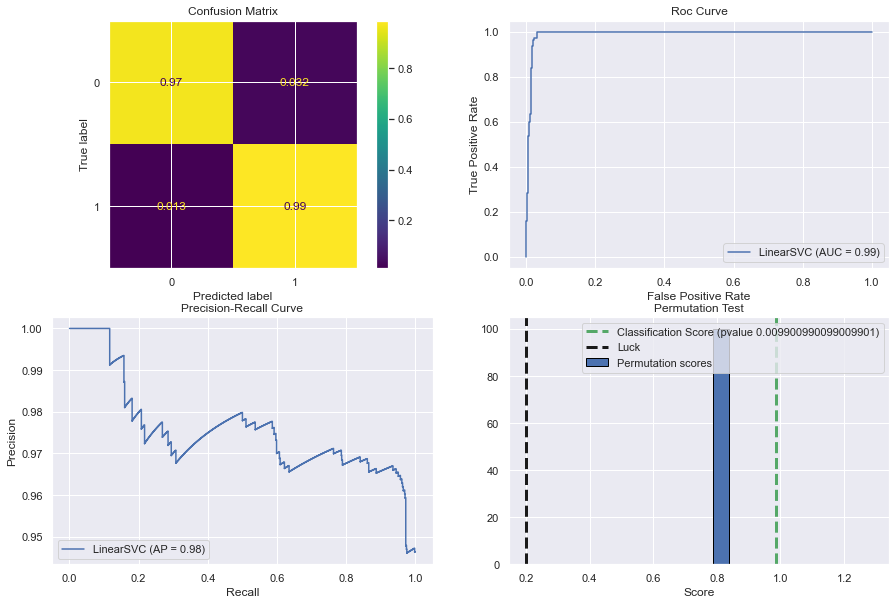


________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='l1')
train time: 0.013s
test time:  0.000s
accuracy:   0.979
dimensionality: 5
density: 0.800000
classification report:
               precision    recall  f1-score   support

    Occupancy       1.00      0.97      0.98      1693
Non-Occupancy       0.95      1.00      0.97       972

     accuracy                           0.98      2665
    macro avg       0.97      0.98      0.98      2665
 weighted avg       0.98      0.98      0.98      2665

permutation test:


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

Classification score 0.9866141943180453 (pvalue : 0.009900990099009901)


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

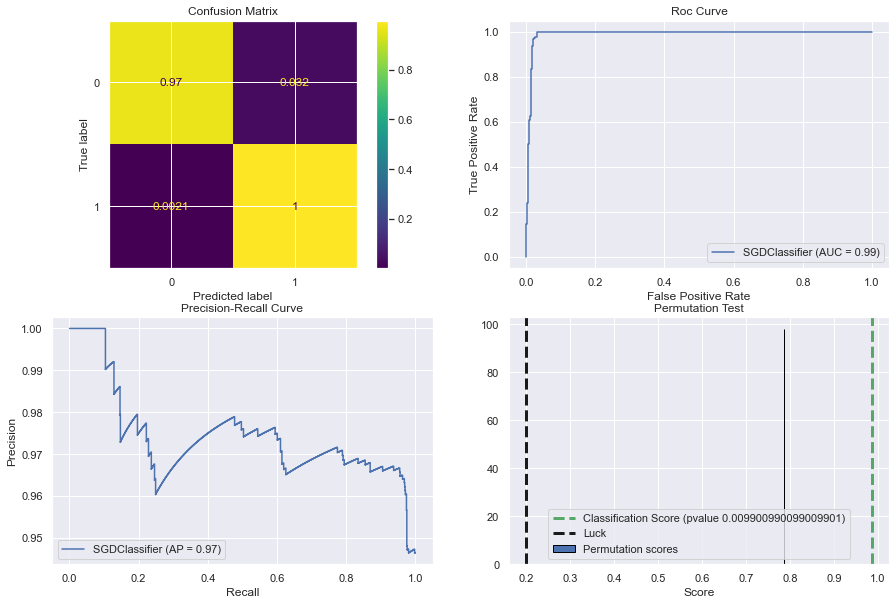


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.014s
test time:  0.001s
accuracy:   0.979
dimensionality: 5
density: 1.000000
classification report:
               precision    recall  f1-score   support

    Occupancy       1.00      0.97      0.98      1693
Non-Occupancy       0.95      1.00      0.97       972

     accuracy                           0.98      2665
    macro avg       0.97      0.98      0.98      2665
 weighted avg       0.98      0.98      0.98      2665

permutation test:


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

Classification score 0.986982533507646 (pvalue : 0.009900990099009901)


C:\Users\Francesco\anaconda3\envs\data-space\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

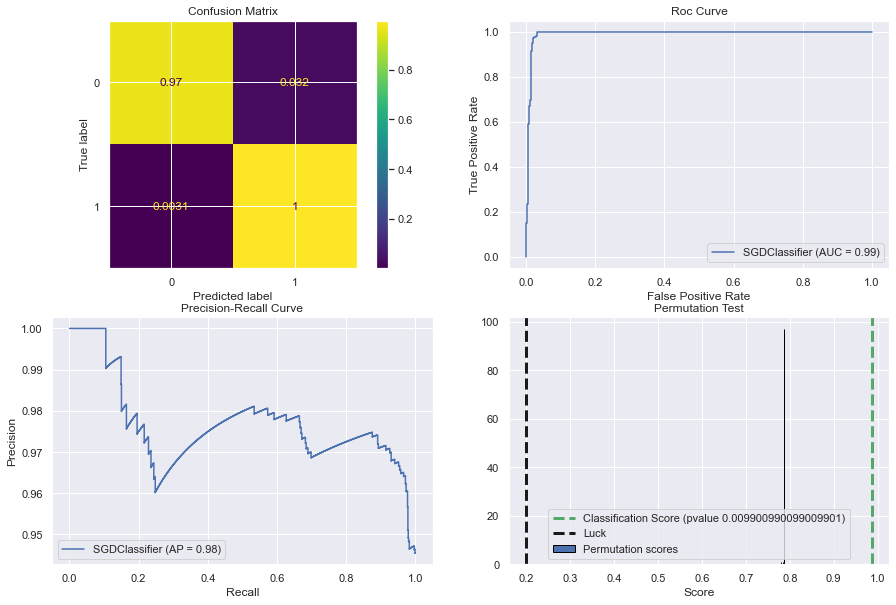


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.002s
test time:  0.001s
accuracy:   0.941
classification report:
               precision    recall  f1-score   support

    Occupancy       0.97      0.94      0.95      1693
Non-Occupancy       0.89      0.95      0.92       972

     accuracy                           0.94      2665
    macro avg       0.93      0.94      0.94      2665
 weighted avg       0.94      0.94      0.94      2665



ValueError: response method decision_function or predict_proba is not defined in NearestCentroid

<Figure size 432x288 with 0 Axes>

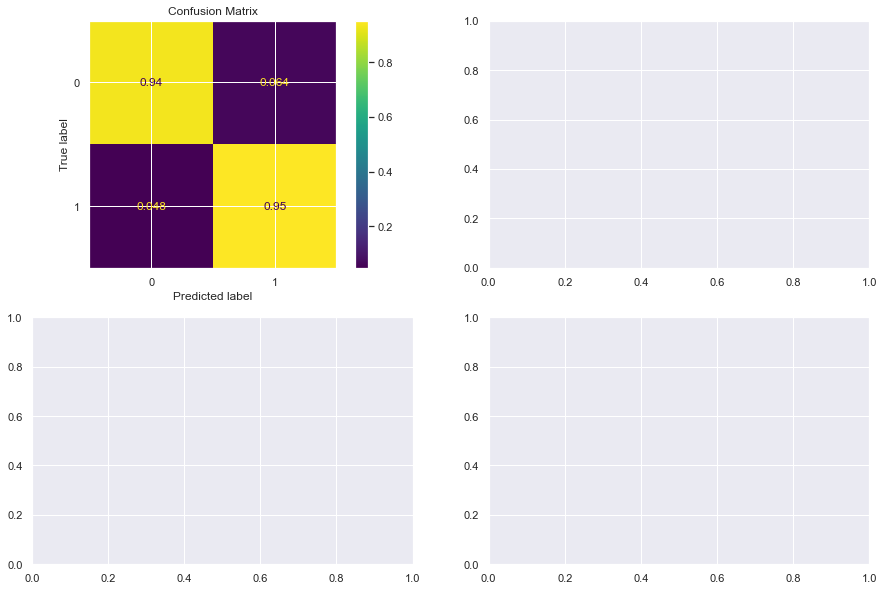

In [18]:
results_benchmark = wrapper_bechmark(
    X_train = X_train, y_train = y_train,
    X_test = X_test, y_test = y_test,
    target_names = target_names,
    feature_names = feature_names, opts = opts,
    save_fig = True, fig_dest = ".")

### Show Benchmark plots

In [ ]:
column_names = "clf_descr,score,train_time,test_time,score(permutation test),pvalue".split(",")
results_benchmark_df = pd.DataFrame(data = results_benchmark, columns = column_names)
results_benchmark_df.to_csv("results_benchmark.csv")

In [ ]:
results_benchmark_df.sort_values(by = "score", ascending = False).style.hide_index()

In [ ]:
results_benchmark_df.sort_values(by = "score", ascending = False).describe().loc[["mean", "std"], :]

In [ ]:
add_plot_banchmark(results_benchmark)

### References

- (Logistic Regression with Keras) https://aigeekprogrammer.com/binary-classification-using-logistic-regression-and-keras/
- (panda-ml) https://pandas-ml.readthedocs.io/en/latest/index.html

### Tutorials
- (K-means) https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
- (Column Transformer with Mixed Types) https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
- (Feature transformations with ensembles of trees) https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
- (Test with permutations the significance of a classification score) https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py
- (Imputing missing values before building an estimator) https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
- (Permutation Importance vs Random Forest Feature Importance (MDI)) https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

### Theory
- (Glossary) https://scikit-learn.org/stable/glossary.html#glossary
- (6.3. Preprocessing data) https://scikit-learn.org/stable/modules/preprocessing.html